# **1 Performance Metrics and Scoring**

**[We should use scikit-plot - this library is gold](https://github.com/reiinakano/scikit-plot)**

In almost all of Kaggle's competitions, the evaluation metric is given to us. However, in reality, when we are solving real world problems in our company, we have to come up with the performance metric ourselves. 

Consider a training set, consisting of 1000 patients, in which we want to correctly classify these patients into whether they have cancer (positive class = 1) or no cancer (negative class = 0) based on some independent variables. Since it is a training set, we have the ground truth data and knows that only $\dfrac{50}{1000}$ of the patients have cancer. We can then come up with a \textbf{trivial classifier} that says:"Classify any patients as no cancer (0)" and this trivial classifier will actually yield you $\dfrac{950}{1000} = 95\%$ \textbf{accuracy}. Does it really mean our \textbf{trivial classifier} is good just because it has an accuracy rate of $95\%$? We shall see.


In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)


hide_toggle()

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import NearMiss
# from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler


%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
#from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import string
import math
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

hide_toggle()

In [3]:
X = pd.read_csv("datasets/X.csv")
y = pd.read_csv("datasets/y.csv")


"\nPlot our target's distribution to see if the classes are balanced. This dataset is moderately balanced.\nBut we can still say it is slightly skewed.\n"

[Text(0, 0, 'Not Survived'), Text(0, 0, 'Survived')]

Text(0, 0.5, 'Frequency Count')

Text(0.5, 1.0, 'Count of Survival')

Text(0.0, 274.5, '549(62%)')

Text(1.0, 171.0, '342(38%)')

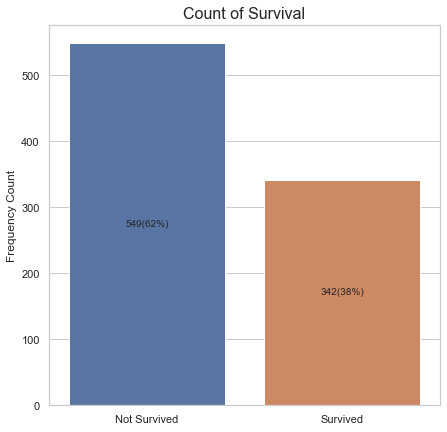

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

'''
Plot our target's distribution to see if the classes are balanced. This dataset is moderately balanced.
But we can still say it is slightly skewed.
'''

figure, survive_bar = plt.subplots(figsize=(7, 7))
sns.barplot(x= y['Survived'].value_counts().index, y = y['Survived'].value_counts(), ax = survive_bar)
survive_bar.set_xticklabels(['Not Survived', 'Survived'])
survive_bar.set_ylabel('Frequency Count')
survive_bar.set_title('Count of Survival', fontsize = 16)

for patch in survive_bar.patches:
    label_x = patch.get_x() + patch.get_width()/2  # find midpoint of rectangle
    label_y = patch.get_y() + patch.get_height()/2
    survive_bar.text(label_x, label_y,
                #left - freq below - rel freq wrt population as a percentage
               str(int(patch.get_height())) + '(' +
               '{:.0%}'.format(patch.get_height()/len(y.Survived))+')',
               horizontalalignment='center', verticalalignment='center')
    
    


In [5]:
'''
Arguments:

1. X - the dataframe X
2. y - the corresponding labels y 


'''

def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(n_splits = 5, shuffle= True, random_state = 42) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [6]:
from sklearn.model_selection import GridSearchCV

'''
Step 1: Define your classifier, in this case, I will just use only one classifier Logistic Regression.
'''

# logreg = LogisticRegression()





'''
classifier: Logistic Regression

classifier_penalty: This indicated the l1: lasso, or l2: ridge

classifier_C: C = 1/lambda, The inverse of regularization strength. Usually lambda is not very big since
a smaller lambda will reduce overfitting by making the model 'simpler'. We search the C parameter over a 
log space We use log scale for hyper-parmaeter optimization because the response function varies on a log scale.
Compare a false-color plot of the hyper-parameter surface for RBF length-scale and C on log and linear scales. 
On a linear scale, in many problems, the plot is basically the same everywhere because the difference between
C=10 and C=11 is basically zero, but the difference between C=10 and C=100 is more pronounced.

classifier_solver: Both liblinear and saga can utilize l1 and l2, so we try both.

grid_of_hyperparameters =  a dictionary containing the necessary hyperparameters.
'''

grid_of_hyperparameters =  {'penalty' : ['l1', 'l2'],
                            'C' : np.logspace(-5,5,30)}



grid = GridSearchCV(estimator = LogisticRegression(solver = 'liblinear'), param_grid = grid_of_hyperparameters,
                    cv = KFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='accuracy', return_train_score=False, n_jobs = -1)

grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jo...
       1.37382380e-01, 3.03919538e-01, 6.72335754e-01, 1.48735211e+00,
       3.29034456e+00, 7.27895384e+00, 1.61026203e+01, 3.56224789e+01,
       7.88046282e+01, 1.74332882e+02, 3.85662042e+02, 8.53167852e+02,
       1.88739182e+03, 4.17531894e+03, 9.23670857e+03, 2.04335972e+04,
       4.

In [7]:
print("grid's best score is:", grid.best_score_)
print("\ngrid's best set of parameters is:", grid.best_params_)
print("\ngrid's best estimator is:", grid.best_estimator_)

logreg = grid.best_estimator_
logreg.fit(X,y)
logreg.score(X,y)

grid's best score is: 0.8339024543343168

grid's best set of parameters is: {'C': 0.6723357536499335, 'penalty': 'l2'}

grid's best estimator is: LogisticRegression(C=0.6723357536499335, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


0.8395061728395061

In [8]:
results = pd.DataFrame(grid.cv_results_)[['params','mean_test_score', 'std_test_score']]
results

,params,mean_test_score,std_test_score
0,"{'C': 1e-05, 'penalty': 'l1'}",0.616195,0.017534
1,"{'C': 1e-05, 'penalty': 'l2'}",0.657711,0.027887
2,"{'C': 2.21221629107045e-05, 'penalty': 'l1'}",0.616195,0.017534
3,"{'C': 2.21221629107045e-05, 'penalty': 'l2'}",0.659952,0.027850
4,"{'C': 4.893900918477499e-05, 'penalty': 'l1'}",0.616195,0.017534
5,"{'C': 4.893900918477499e-05, 'penalty': 'l2'}",0.664440,0.029369
6,"{'C': 0.00010826367338740541, 'penalty': 'l1'}",0.616195,0.017534
7,"{'C': 0.00010826367338740541, 'penalty': 'l2'}",0.667805,0.032657
8,"{'C': 0.0002395026619987486, 'penalty': 'l1'}",0.616195,0.017534
9,"{'C': 0.0002395026619987486, 'penalty': 'l2'}",0.668910,0.029093


In [9]:
'''
logreg is our best estimator now. For illustration purposes, I am going to do cross validation again using our ideal
estimator logreg.

'''
from sklearn.model_selection import cross_validate

res = cross_validate(logreg, X,y,
                     cv = KFold(n_splits=10, shuffle=True, random_state=42),
                     scoring=["accuracy", "recall", "precision","roc_auc"],
                     return_train_score=True)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
0,0.004986,0.005984,0.844444,0.835206,0.833333,0.761438,0.789474,0.797945,0.911523,0.874223
1,0.003989,0.005985,0.797753,0.836658,0.736842,0.756579,0.777778,0.801394,0.863261,0.877939
2,0.003989,0.005984,0.808989,0.840399,0.702703,0.770492,0.812500,0.802048,0.871622,0.879909
3,0.003988,0.004987,0.808989,0.844140,0.666667,0.778846,0.740741,0.812709,0.793785,0.885881
4,0.003989,0.003989,0.842697,0.839152,0.842105,0.779605,0.800000,0.792642,0.884933,0.878904
5,0.003496,0.003989,0.887640,0.831671,0.812500,0.751613,0.866667,0.800687,0.909539,0.874725
6,0.002991,0.003989,0.820225,0.844140,0.666667,0.776699,0.814815,0.810811,0.849026,0.882927
7,0.003989,0.004987,0.775281,0.837905,0.666667,0.763754,0.709677,0.805461,0.813582,0.885333
8,0.003989,0.004987,0.775281,0.837905,0.700000,0.751656,0.777778,0.804965,0.856122,0.879189
9,0.003989,0.003990,0.865169,0.831671,0.840000,0.766562,0.724138,0.799342,0.942500,0.872532


In [10]:
'''
A generic function to compute generic metrics for a binary classification question
Arguments:

1. X - the dataframe X
2. y - the corresponding labels y 


'''

def printing_Kfold_scores(X,y):
    
    

    j = 0
    
    k_fold = KFold(n_splits = 5, shuffle= True, random_state = 42) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')
        
        
        accuracy_list  = []
        recall_list    = []
        precision_list = []
        
        # used to increment each iteration by 1 in string later.
        loop = 1
        for train_index, test_index in k_fold.split(X):
            
            
            train_X, test_X = X.values[train_index], X.values[test_index]
            y_train_true, y_test_true = y.values.ravel()[train_index], y.values.ravel()[test_index]            

            # define our model
            model = LogisticRegression(C = c_param, penalty = 'l2', solver = 'liblinear')
            
            # fit our model
            model.fit(train_X, y_train_true)
            
            
            # Predict class labels in test_X
            y_pred = model.predict(test_X)
            
            # choose your scorer, we include some of the more common classification metrics here
            accuracy  = accuracy_score(y_test_true, y_pred)
            recall    = recall_score(y_test_true, y_pred)
            precision = precision_score(y_test_true, y_pred)
            

            # Calculate the metrics score and append it to a list for the metric
            # scores representing the current c_parameter.

            accuracy_list.append(accuracy)
            recall_list.append(recall)
            precision_list.append(precision)
            
            print('Iteration ', loop,': accuracy score = ', accuracy)
            print('Iteration ', loop,': recall score = ', recall)
            print('Iteration ', loop,': precision score = ', precision)
            loop = loop + 1
            
        # The mean value of those recall scores is the metric we want to save and get hold of after 5 fold validation
        # for this particular hyperparameter.
        
        results_table.ix[j,'Mean accuracy score'] = np.mean(accuracy_list)
        results_table.ix[j,'Mean recall score'] = np.mean(recall_list)
        results_table.ix[j,'Mean precision score'] = np.mean(precision_list)
        j += 1
        print('')
        print('Mean accuracy score ', np.mean(accuracy_list))
        print('Mean recall score ', np.mean(recall_list))
        print('Mean precision score ', np.mean(precision_list))
        print('')
        
        # get std as well
        
        
        
    print(results_table)
    best_c = results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [11]:
printing_Kfold_scores(X,y)

#Mean recall score  0.7527234766040736


-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : accuracy score =  0.7877094972067039
Iteration  1 : recall score =  0.5945945945945946
Iteration  1 : precision score =  0.8461538461538461
Iteration  2 : accuracy score =  0.7921348314606742
Iteration  2 : recall score =  0.582089552238806
Iteration  2 : precision score =  0.8125
Iteration  3 : accuracy score =  0.8707865168539326
Iteration  3 : recall score =  0.7428571428571429
Iteration  3 : precision score =  0.9122807017543859
Iteration  4 : accuracy score =  0.7696629213483146
Iteration  4 : recall score =  0.5151515151515151
Iteration  4 : precision score =  0.7906976744186046
Iteration  5 : accuracy score =  0.7865168539325843
Iteration  5 : recall score =  0.5230769230769231
Iteration  5 : precision score =  0.8292682926829268

Mean accuracy score  0.8013621241604418
Mean recall score  0.5915539455837964
Mean precision score  0.8381801030019528

---------

1.0

In [12]:
c_param_range = [0.01,0.1,1,10,100]
results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
results_table

,C_parameter,Mean recall score


Confusion matrix, without normalization
[[154  21]
 [ 28  92]]
Normalized confusion matrix
[[0.88 0.12]
 [0.23 0.77]]


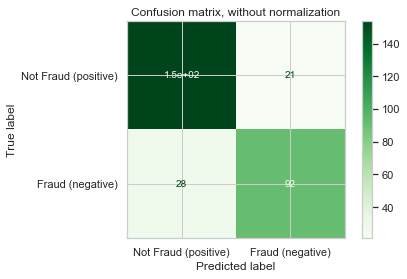

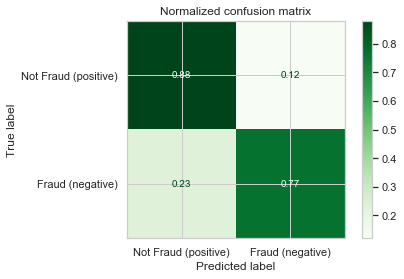

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with

X = pd.read_csv("datasets/X.csv")
y = pd.read_csv("datasets/y.csv")

class_names = ['Not Fraud (positive)', 'Fraud (negative)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize, values_format = '')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


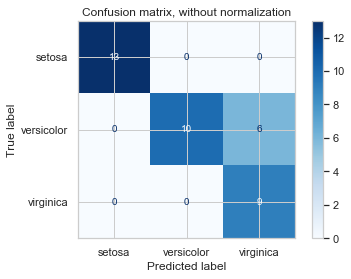

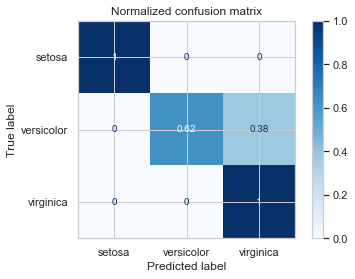

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

[scikit-learn plot confusion matrix documentation is as of below](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [15]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## 1.1 Business Goals

# **2 Metrics for Binary Classification**

## **2.1 Accuracy**

### 2.1.1 Definition

[sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


- Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:
    $$\text{Accuracy} = \dfrac{\text{Number of correctly classified cases}}{\text{Number for all cases}}$$

<br>
    
- In the Binary setting, we can also write the formula as such: $$\text{Accuracy} = \dfrac{TP+TN}{TP+TN+FP+FN}$$

### 2.1.2 When to use Accuracy as a metric

Classes are well balanced: Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or no class imbalance. Typically, one should plot EDA and see the classes - if they are roughly equal, then `accuracy` can be used.

### 2.1.3 When NOT to use Accuracy as a metric

- Classes are *severely* imbalanced.


- In general, `accuracy` is a very basic metric, and may not tell you any more information that fits your business needs. However, understanding this easiest metric first is crucial to facilitate the next few sections. You almost never ever use `accuracy` as a single metric, see 2.5 for intuition.

 Consider a class imbalanced set, where the training data set has 100 patients (data points), and the ground truth is 90 patients are of class = 0, which means that these patients do not have cancer, whereas the remaining 10 patients are in class 1, where they do have cancer. This is an example of class imbalance where the ratio of class 1 to class 0 is a mere $1:9$.
    

    
Consider \textbf{a baseline (almost trivial) classifier}, where we predict the patient's class as the most frequent class. Meaning, the most frequent class in this question is the class = 0, where patients do not have cancer, so we just assign this class to everyone in this set. By doing this, we will inevitably achieve a accuracy rate of $\frac{90}{100} = 90\%$. But unfortunately, this supposedly high accuracy value is completely useless, because this classifier did not label any of the cancer patients correctly.

What did we conclude? Well, for one, our `accuracy` can be 90% high and looks good to the laymen, but it failed to predict the most important class of people - yes, misclassifying true cancer patients as healthy people is an offense. 

## **2.2 Confusion Matrix**

### 2.2.1 Definition

[sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In binary classification (can be extended to multi class), a table of confusion (sometimes also called a confusion matrix), is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications `Accuracy metric`. Accuracy is not a reliable metric for the real performance of a classifier, because it will yield misleading results if the data set is imbalanced (that is, when the numbers of observations in different classes vary greatly).


A confusion matrix is an N X N matrix, where N is the number of classes being predicted. Confusion Matrix gives us a matrix as output and describes the complete performance of the model. In a Binary setting, N = 2, so the confusion matrix is 2x2.

The correct predictions falls on the diagonal line of the matrix.

4 important terms in Confusion Matrix:

- True Positives : The cases in which we predicted YES and the actual output was also YES.
- True Negatives : The cases in which we predicted NO and the actual output was NO.
- False Positives : The cases in which we predicted YES and the actual output was NO.
- False Negatives : The cases in which we predicted NO and the actual output was YES.

### 2.2.2 When to use Confusion Matrix?

You use it everywhere. The Confusion matrix in itself is not a performance measure, but the information that it carries is so valuable that almost all the other classification metrics will need to refer to the confusion matrix.

In [16]:
from sklearn.metrics import confusion_matrix

y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

## **2.3 Precision**

### 2.3.1 Definition

[sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

- Precision is also known as Positive Predictive Rate (PPV).


- Precision is the number of True Positive divided by the number of Positives predicted by the classifier.


- Precision measures how many of the samples predicted as positive are actually positive.

$$\text{Precision} = \dfrac{\text{TP}}{\text{TP} + \text{FP}}$$


- One sees that the formula of precision, the intuition is as True Positives goes up or False Positives goes down, **precision goes up**. But if you think further, TP and FP complements each other since they are related by the formula 

$$\text{Predicted Number of Positives} = \text{TP} + \text{FP}$$    
$$\text{Therefore, minimizing FP is equivalent to maximizing TP.}$$


- The formula is also suggesting that we are ignoring about False negatives rates here.

### 2.3.2 When to use `precision`?

- When your company needs you to ***restrict the number of False Positives***.


- In other words, as we will see later, there is a trade off between precision and recall, and restricting the number of FP ***may*** give rise to the increase in FN. So ultimately, bear in mind that it is not simply a matter of ***restricting the number of False Positives*** but a matter of ***in your business setting, whether achieving less FP is more important than achieving a less FN***.


- In general, precision - recall curve, as we will see later, gives a better overview of 'accuracy' than `accuracy score`.

#### 2.3.2.1 Example on using `precision`

Consider a pharmaceutical company named *Preggie* in China that has developed a new testing kit to detect pregnancy. The company tested its kits on 10,000 ladies in the Wuhan city - these 10,000 ladies are our training samples. There are two outcomes/classes, 
- positive class = pregnant
- negative class = not pregnant

This clinical trial involving 10,000 ladies involves a random sampling (and we assume the classes are quite balanced). The Data Scientists in Preggie needs to come up with a binary classification model that predicts the "accuracy" of their testing kit. Of course, the data scientists in Preggie are smart, they evaluate their classifier/model not by their `accuracy` but by their `precision` instead. 

This is because they want to minimize their False Positives in their classifier. From the company's perspective, they want their testing kit to **correctly identify as much positive pregnancy cases as possible**. If their testing kit has a lot of False Positives, it will drive many of their customers to make the wrong decision - like quickly getting married and buying houses. The company care less about False Negatives because you will eventually find out that you are pregnant even if the initial testing kit shows otherwise.

### 2.3.3 When NOT to use `precision`?

- When you prioritize recall/sensitivity more than precision for your business needs.

- You almost never ever use `precision` as a single metric, see 2.5 for intuition.

## **2.4 Recall/Sensitivity**

### 2.4.1 Definition

[sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

- Recall, otherwise known as True Positive Rate (TPR) or Sensitivity, attempts to answer
the question on: out of all the actual positives (the real cancer patients),
how many of them were identified correctly by our classifier? And since TP + FN gives you the actual number of positives,
it’s formula is unsurprisingly defined by

$$\text{Recall}= \dfrac{\text{TP}}{\text{TP} + \text{FN}}$$

- Another way to construct the formula can be easily seen when you have your end goal in mind. If your end goal is to correctly classify all actual positives as actual positives, that is, if the sample's ground truth label is positive, you want your classifier to predict all samples with positive label with as much accuracy as possible. Since 
$$\text{Actual Number of Positives = TP + FN}$$ 
it is therefore easy to see that minimizing FN is also maximizing TP.

### 2.4.2 When to use `recall`?

- When your company needs you to ***restrict the number of False Negatives***.


- Recall/Sensitivity therefore quantifies the avoidance of False Negatives.



#### 2.4.2.1 Example on `recall`

For disease data modeling, anything that doesn't account for false-negatives is a crime. Recall is a better measure than precision.

### 2.4.3 When to NOT use `recall`?

- When you prioritize precision more than recall for your business needs.

- You almost never ever use `recall` as a single metric, see 2.5 for intuition.

## **2.5 Precision-Recall Curve**

### 2.5.1 Loss function and decision Function

[Loss function and decision Function link](https://stats.stackexchange.com/questions/104988/what-is-the-difference-between-a-loss-function-and-decision-function)

A **decision function** is a function which takes a dataset as input and gives a decision as output. What the decision can be depends on the problem at hand. Examples include:

 - *Estimation problems:* the "decision" is the estimate.
 - *Hypothesis testing problems:* the decision is to reject or not reject the null hypothesis. Think of Linear Regression problems, they are mostly related to hypothesis testing.
 - *Classification problems:* the decision is to classify a new observation (or observations) into a category.
 - *Model selection problems:* the decision is to chose one of the candidate models.

Typically, there are an infinite number of decision functions available for a problem. If we for instance are interested in estimating the height of Swedish males based on ten observations $\mathbf{x}=(x_1,x_2,\ldots,x_{10})$, we can use any of the following decision functions $d(\mathbf{x})$:

 - The sample mean: $d(\mathbf{x})=\frac{1}{10}\sum_{i=1}^{10}x_i$.
 - The median of the sample: $d(\mathbf{x})=\mbox{median}(\mathbf{x})$
 - The geometric mean of the sample: $d(\mathbf{x})=\sqrt[10]{x_1\cdots x_{10}}$
 - The function that always returns 1: $d(\mathbf{x})=1$, regardless of the value of $\mathbf{x}$. Silly, yes, but it is nevertheless a valid decision function.

How then can we determine which of these decision functions to use? One way is to use a **loss function**, which describes the loss (or cost) associated with all possible decisions. Different decision functions will tend to lead to different types of mistakes. The loss function tells us which type of mistakes we should be more concerned about. The best decision function is the function that yields the lowest **expected loss**. What is meant by expected loss depends on the setting (in particular, whether we are talking about [frequentist][1] or [Bayesian][2] statistics).

**In summary:** 

 - Decision functions are used to make decisions based on data.
 - Loss functions are used to determine which decision function to use.


  [1]: http://en.wikipedia.org/wiki/Frequentist_inference
  [2]: http://en.wikipedia.org/wiki/Bayesian_statistics

### 2.5.2 An extensive study on Precision-Recall Curve



Before I start, I will quote [Frank Harrell's first](https://www.fharrell.com/post/classification/) and [his second](http://www.fharrell.com/2017/03/damage-caused-by-classification.html) article. I will also use the links on stack exchange [here](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models) and [here](https://stats.stackexchange.com/questions/368949/example-when-using-accuracy-as-an-outcome-measure-will-lead-to-a-wrong-conclusio) by [Stephan Kolassa](https://stats.stackexchange.com/users/1352/stephan-kolassa). They are really good and the entire intuition is from him, I will almost use his intuition verbatim and everything in this section will be credited to the links above; I just find it too difficult to phrase it in my own words because their answers are perfect.

Basically, let me put it up front now: ***Accuracy, Sensitivity and Specificity are one-sided or conditional versions of classification accuracy. As such they are also discontinuous improper accuracy scores, and optimizing them will result in the wrong model.***  



The `confusion matrix` and the `classification report` provide a very detailed analysis of a particular set of predictions. However, the predictions themselves already threw away a lot of information that is contained in the model - to explain this statement further: We consider the example of a logistic regression classifier, used to predict whether a patient has cancer (1, positive class) or not (0, negative class). We defined Y as our response variable, outputting only 1 or 0, while X is the set of predictors.

In the case of our cancer classification model, (which we assume to be a logistic regression classifier), we remember that the positive class (class = 1) is the patient has cancer, and the negative class (class = 0) is the patient does not have cancer. And to delve a little deeper, our default classification threshold is:
    
$\begin{equation}
 Y=\begin{cases}
1, & \text{if $P(Y=1 ~|~X) \geq 0.5$}\\
0, & \text{if $P(Y=1~|~X) < 0.5$}\\
\end{cases} \end{equation}$

which means that whenever our logistic regression outputs a probability of the patient getting cancer is more than $0.5$, we classify the patient to be in the positive class (predict him/her to have cancer). When we use the `LogisticClassifier()` to fit and predict, we are actually predicting the probability $p(X)$, i.e.the probability of the patient having cancer given predictors X; Consequently, we need to further set a threshold, or to make a decision on whether to classify a patient as cancer or benign based on the probability we get from $$p(X) = \dfrac{e^{\beta_0}+\beta_1X_1+...+\beta_nX_n}{1+ e^{\beta_0}+\beta_1X_1+...+\beta_nX_n}$$

The threshold is defaulted to 0.5 in `predict_proba`. As we discussed earlier, most classifiers provide a `decision_function` or a `predict_proba` method to assess degrees of certainty about predictions. Making predictions can be seen as thresholding the output of `decision_function` or `predict_proba` at a certain fixed point; in binary classification we use 0 for the decision function and 0.5 for predict_proba as default.


<br>


To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. Explore this notion by looking at the following figure, which shows 30 predictions made by an email classification model. Those to the right of the classification threshold are classified as "spam", while those to the left are classified as "not spam."

Always remember, do not ever just use a single metric like `recall, precision` to gauge your classifier. This is because your stupid classifier (say `SVM()` may somehow trivially classify everything as the positive class,  and then you will get 100% recall).

### 2.5.x When to use Precision-Recall

[Precision-Recall paper](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)
Precision-Recall curves should be used when there is a moderate to large class imbalance.

Precision and recall, however, don't consider true negatives and thus won't be affected by the relative imbalance (which is precisely why they're used for imbalanced datasets). 


[Kaggle Forum](https://www.kaggle.com/general/7517#41179)

As goes for any metric, your metric depends entirely on what I you mean to do with the data.

I think intuitively you can say that if your model needs to perform equally well on the positive class as the negative class (for example, for classifying images between cats and dogs, you would like the model to perform well on the cats as well as on the dogs. For this you would use the ROC AUC.

On the other hand, if you're not really interested in how the model performs on the negative class, but just want to make sure every positive prediction is correct (precision), and that you get as many of the positives predicted as positives as possible (recall), then you should choose PR AUC. For example, for detecting cancer, you don't care how many of the negative predictions are correct, you want to make sure all the positive predictions are correct, and that you don't miss any. (In fact, in this case missing a cancer would be worse then a false positive so you'd want to put more weight towards recall.)

True negatives need to be meaningful for ROC to be a good choice of measure. In his example, if we've got 1,000 pictures of cats and dogs and our model determines whether the picture is a cat (target = 0) or a dog (target = 1), we probably care just as much about getting the cats right as the dogs, and so ROC is a good choice of metric.

If instead, we've got a collection of 1,000,000 pictures and we build a model to try to identify the 1,000 dog pictures mixed in it, correctly identifying "not-dog" pictures is not quite as useful. Instead, it makes more sense to measure how often a picture is a dog when our model says it's a dog (i.e., precision) and how many of the dogs in the picture set we found (i.e., recall).

In [17]:
# # Import what's needed for the Functions API
# import matplotlib.pyplot as plt
# import scikitplot as skplt

# # This is a Keras classifier. We'll generate probabilities on the test set.
# keras_clf.fit(X_train, y_train, batch_size=64, nb_epoch=10, verbose=2)
# probas = keras_clf.predict_proba(X_test, batch_size=64)

# # Now plot.
# skplt.metrics.plot_precision_recall_curve(y_test, probas)
# plt.show()

## ROC

Say we use Naive Bayes in multi-class classification and decide we want to visualize the results of a common classification metric, the Area under the Receiver Operating Characteristic curve. Since the ROC is only valid in binary classification, ***we want to show the respective ROC of each class if it were the positive class (very important concept).*** As an added bonus, let's show the micro-averaged and macro-averaged curve in the plot as well.

Let's use scikit-plot with the sample digits dataset from scikit-learn.

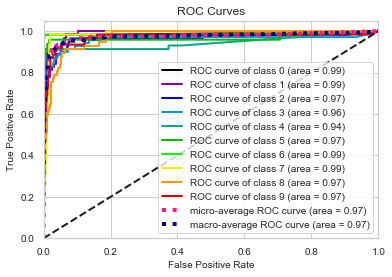

In [18]:
# The usual train-test split mumbo-jumbo
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
nb = GaussianNB()
nb.fit(X_train, y_train)
predicted_probas = nb.predict_proba(X_test)
predicted_probas
# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()

In [19]:
# The usual train-test split mumbo-jumbo
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predicted_probas = logreg.predict_proba(X_test)


# The magic happens here
import matplotlib.pyplot as plt
import scikitplot as skplt
# skplt.metrics.plot_roc(y_test, predicted_probas)
# plt.show()

Number of data points :: 150
Number of features :: 4
Accuracy of SVC on training set: 97.50
Accuracy of SVC on test set: 100.00


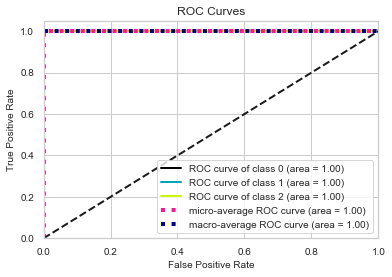

In [20]:
iris = datasets.load_iris()
X = iris.data[:, :]
y = iris.target
print ("Number of data points ::", X.shape[0])
print("Number of features ::", X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42)



from sklearn.svm import SVC

clf_SVC = SVC(random_state = 42, probability = True)
clf_SVC.fit(X_train,y_train)

print('Accuracy of SVC on training set: {:.2f}'.format(clf_SVC.score(X_train, y_train) * 100))

print('Accuracy of SVC on test set: {:.2f}'.format(clf_SVC.score(X_test, y_test) * 100))

y_pred = clf_SVC.predict_proba(X_test)
y_pred

# import matplotlib.pyplot as plt
# import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_pred)
plt.show()

In [21]:
# The usual train-test split mumbo-jumbo

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


# Import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :]
y = iris.target

X
y

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                    random_state = 42)


from sklearn.svm import LinearSVC

from sklearn.svm import SVC

clf_SVC = SVC(C=100.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
          probability=False, tol=0.001, cache_size=200, class_weight=None, 
          verbose=0, max_iter=-1, decision_function_shape="ovr", random_state = 0)
clf_SVC.fit(X_train,y_train)




y_pred = clf.predict(X_test)

# Learn to predict each class against the other
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state))
# y_pred = classifier.fit(X_train, y_train).decision_function(X_test)

y_pred
# # The magic happens here
# import matplotlib.pyplot as plt
# import scikitplot as skplt
# skplt.metrics.plot_roc(y_test, y_pred)
# plt.show()

ValueError: bad input shape (105, 3)

## **2.6 Specificity/True Negative Rate (TNR)**

### 2.5.1 Definition

[sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

Precision is the number of True Positive divided by the number of positive results predicted by the classifier.

$$Precision= \dfrac{TP}{TP + FP}$$


### 2.5.2 When to use `Specificity`?

### 2.5.3 When to NOT use `Specificity`?

## **2.7 F1 Score**

### 2.6.1 Definition

### 2.6.2 When to use F1 Score

### 2.6.3 When to NOT use F1 Score

## **2.7 Classification Report**

## **2.8 Precision - Recall Tradeoff Curves**

## **2.9 ROC Curves**

# **3 Metrics for Regression**